# Introduction

This is the Biodiversity Portfolio Project from Codecademy's Data Science Course. The project aims to explore a dataset and answer the following questions:

1) What is the distribution of conservation status for species in the parks?
2) Are certain types of species more likely to be in a protected species category?
3) Are there significant differences between species and their conservation status?
4) What are the most commonly observed mammals in each park?

Data sources:
The project uses two data sources: 'Observations.csv' and 'Species_info.csv', both provided by Codecademy.com (https://www.codecademy.com).

Scope the Data

In [1]:
# Load the data
import pandas as pd

observations = pd.read_csv("observations.csv")
species = pd.read_csv("species_info.csv")

In [2]:
# Examine the observations data
print(observations.info())
observations.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23296 entries, 0 to 23295
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  23296 non-null  object
 1   park_name        23296 non-null  object
 2   observations     23296 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 546.1+ KB
None


,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


In [3]:
# Examine the species info data
print(species.info())
species.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  191 non-null    object
dtypes: object(4)
memory usage: 182.1+ KB
None


,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


Takeaways from initial data exploration:
1) The column 'conservation_status' in the 'species' file has many null values
2) The two dataframes share a common column, "scientific_name"

Explore the Data Further

In [4]:
print("# of unique species observed:", observations.scientific_name.nunique())
print("# of parks included in this dataset:", observations.park_name.nunique(), observations.park_name.unique())

print("# of unique species in these parks:", species.category.nunique(), species.category.unique())
print("# of unique conservation statuses:", species.conservation_status.nunique(dropna = False), species.conservation_status.unique())

# of unique species observed: 5541
# of parks included in this dataset: 4 ['Great Smoky Mountains National Park' 'Yosemite National Park'
 'Bryce National Park' 'Yellowstone National Park']
# of unique species in these parks: 7 ['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant']
# of unique conservation statuses: 5 [nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']


In [5]:
# Replace the 'nan' consservation status with "No Intervention"
species.conservation_status.fillna("No Intervention", inplace = True)

Analysis

Q1) What is the distribution of species by conservation status?

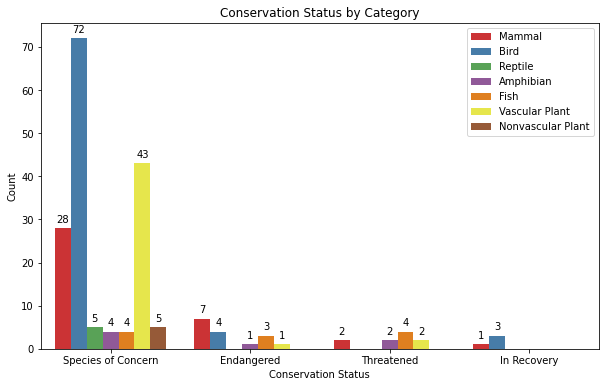

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of species by conservation status (excluding 'No Intervention")
plt.figure(figsize=(10,6))
ax = sns.countplot(data = species[species.conservation_status != "No Intervention"], x='conservation_status', hue='category', palette='Set1')
plt.xlabel("Conservation Status")
plt.ylabel("Count")
plt.title("Distribution of Conservation Status")
plt.legend(loc = 'upper right')

# Add counts above each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')


plt.xlabel("Conservation Status")
plt.title("Conservation Status by Category")
plt.show()

Q2) Are certain species more likely to be in a protected conservaton category?

The results below show 17% of mammals and 15.4% of Birds have a protected conservation status.

In [7]:
# Create a new column labelled 'protected'
species['protected'] = species.conservation_status != "No Intervention"

# Create pivot table to show how many species in each category are protected and not protected
protected_counts = species.groupby(['category', 'protected']).scientific_name.nunique().reset_index()
protected_pivot = protected_counts.pivot(index='category', columns='protected', values='scientific_name').reset_index()
protected_pivot.columns = ['Category', 'Not Protected', 'Protected']
protected_pivot['% Protected'] = round(100*protected_pivot.Protected/(protected_pivot.Protected + protected_pivot["Not Protected"]),1)
print(protected_pivot)

# Print out the table with category and % protected
print(protected_pivot[['Category', '% Protected']])


            Category  Not Protected  Protected  % Protected
0          Amphibian             72          7          8.9
1               Bird            413         75         15.4
2               Fish            115         11          8.7
3             Mammal            146         30         17.0
4  Nonvascular Plant            328          5          1.5
5            Reptile             73          5          6.4
6     Vascular Plant           4216         46          1.1
            Category  % Protected
0          Amphibian          8.9
1               Bird         15.4
2               Fish          8.7
3             Mammal         17.0
4  Nonvascular Plant          1.5
5            Reptile          6.4
6     Vascular Plant          1.1


Q3) Are the differences between species and their conservation status significant?

We will use two chi-squared tests to determine if these two categories have significantly different protected ratio than the other species.

First Test:
* Null hypothesis: There is no significant difference in the % of Mammals that are protected vs other categories.

* Alternative hypothesis: There is a significant difference between the % of Mammals that are protected vs other categories.
(Chosen p-value is 0.05)

Results: pval (5.77e-25) is significantly less than 0.05. Mammals are statistically more likely to be protected than other species

In [8]:
from scipy.stats import chi2_contingency

# Create a contingency table of category vs protected
cont_table = protected_pivot[["Protected", "Not Protected"]]
print(cont_table)

# Perform the chi-squared test for Mammals and other categories
mammals_cont_table = cont_table.loc[protected_pivot["Category"] == "Mammal"]
other_cont_table = cont_table.loc[protected_pivot["Category"] != "Mammal"]

chi2_mammals, pval_mammals, dof_mammals, expected_mammals = chi2_contingency([mammals_cont_table.sum(), other_cont_table.sum()])

print("Chi-squared statistic for Mammals vs Other Categories:", chi2_mammals)
print("p-value for Mammals vs Others:", pval_mammals)


   Protected  Not Protected
0          7             72
1         75            413
2         11            115
3         30            146
4          5            328
5          5             73
6         46           4216
Chi-squared statistic for Mammals vs Other Categories: 106.48575412002755
p-value for Mammals vs Others: 5.770583896030514e-25


Second Test:
* Null hypothesis: There is no significant difference in the % of Birds that are protected than other categories.

* Alternative hypothesis: There is a significant difference between the % of Birs that are protected vs other categories.
(Chosen p-value is 0.05)

Results: pval (6.94e-56) is significantly less than 0.05. Birds are significantly more likely to be protected than other species

In [9]:
# Perform the chi-squared test for Birds and other categories
birds_cont_table = cont_table.loc[protected_pivot["Category"] == "Bird"]
other_cont_table = cont_table.loc[protected_pivot["Category"] != "Bird"]
chi2_birds, pval_birds, dof_birds, expected_birds = chi2_contingency([birds_cont_table.sum(), other_cont_table.sum()])
print("Chi-squared statistic for Birds vs Other Categories:", chi2_birds)
print("p-value for Birds vs Others:", pval_birds)


Chi-squared statistic for Birds vs Other Categories: 248.04168080289367
p-value for Birds vs Others: 6.940288342727028e-56


Next we explore observations of each species category by park:
From the plot below, Vascular Plants are the most commonly observed category for each park, followed by Birds.
Yellowstone had the most observations across each category.


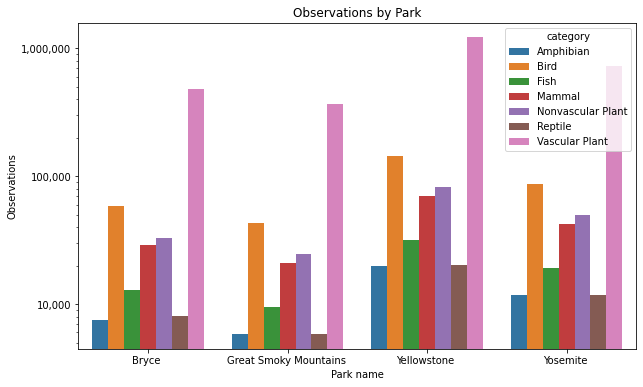

<Figure size 432x288 with 0 Axes>

In [10]:
# Merge the two dataframes based on the scientific_name
merged_df = observations.merge(species, on='scientific_name')
merged_df['park_name'] = merged_df.park_name.str.replace('National Park', '')

# Group the data by park name and category, and sum the observations
grouped_df = merged_df.groupby(['park_name', 'category'])['observations'].sum().reset_index()

# Create a side by side barplot with seaborn
plt.figure(figsize = (10,6))
ax = sns.barplot(x='park_name',y = 'observations', hue='category', dodge = True, data=grouped_df)

# Set the title and axis labels
plt.title('Observations by Park')
plt.xlabel('Park name')
plt.ylabel('Observations')
plt.yscale('log')

# Format y-axis tick labels with commas
import matplotlib.ticker as ticker
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Show the plot
plt.show()
plt.clf()

Q4) What are the most commonly observed mammals in each park?

In [12]:
# Filter the data to include only mammal species
mammals_df = merged_df[merged_df.category == 'Mammal'].drop(columns=['conservation_status', 'protected', 'category'])

# Group by park_name and scientific_name, calculate sum of observations
grouped_df = mammals_df.groupby(['park_name', 'scientific_name']).observations.sum().reset_index()

# Sort by park_name and summed observations in descending order
sorted_df = grouped_df.sort_values(['park_name', 'observations'], ascending=[True, False])

# Get the top 3 observed mammals for each park
top_3_mammals = sorted_df.groupby('park_name').head(3)

# Merge with species dataframe to include common_names
merged_top_3 = top_3_mammals.merge(species[['scientific_name', 'common_names']], on='scientific_name', how='left')

# Combine multiple common names into a single value by retrieving the unique names and combining them with a comma
combined_common_names = merged_top_3.groupby('scientific_name')['common_names'].apply(lambda x: ', '.join(x.dropna().unique()))

# Update the common_names column in the merged dataframe
merged_top_3['common_names'] = merged_top_3['scientific_name'].map(combined_common_names)

import re

# Remove duplicates in common_names column
def remove_duplicates(common_names):
    names = []
    for name in common_names.split(', '):
        if '(' in name:
            match = re.search(r'\((.*?)\)', name)
            if match:
                extracted_name = match.group(1)
                if extracted_name not in names:
                    names.append(extracted_name)
        else:
            if name not in names:
                names.append(name)
    return ', '.join(names)

merged_top_3['common_names'] = merged_top_3['common_names'].apply(remove_duplicates)

# Remove duplicates
merged_top_3 = merged_top_3.drop_duplicates(subset=['park_name', 'scientific_name'])

# Print the results
for park_name, group in merged_top_3.groupby('park_name'):
    print(park_name)
    print(group[['scientific_name', 'common_names', 'observations']])
    print()


Bryce 
     scientific_name                           common_names  observations
0      Puma concolor            Mountain Lion, Cougar, Puma           933
3   Myotis lucifugus  Little Brown Bat, Little Brown Myotis           894
6  Castor canadensis                American Beaver, Beaver           834

Great Smoky Mountains 
      scientific_name                               common_names  observations
9       Procyon lotor  Common Raccoon, Raccoon, Northern Raccoon           741
12  Castor canadensis                    American Beaver, Beaver           729
15      Puma concolor                Mountain Lion, Cougar, Puma           717

Yellowstone 
      scientific_name                               common_names  observations
18      Puma concolor                Mountain Lion, Cougar, Puma          2259
21      Procyon lotor  Common Raccoon, Raccoon, Northern Raccoon          2235
24  Castor canadensis                    American Beaver, Beaver          2109

Yosemite 
      scientific